# Кластеризация

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap.umap_ as umap
import warnings

from sklearn.cluster import DBSCAN

## Обработка данных

Наш исходный набор данных уже не содержит пропущенных значений, поэтому данные можно считать нормализованными.

In [2]:
df = pd.read_csv('../data/SpotifyFeatures.csv')
df

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489


Так же, как и в прошлой лабораторной, в качестве категории для объектов выберем класс популярности.

In [3]:
df['popularity_class'] = df.apply(lambda row: 2 if row.popularity > 80 else 1 if row.popularity > 50 else 0, axis=1)
df

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity_class
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,0
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,0
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,0
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,0
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962,0
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969,0
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813,0
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489,0


Уменьшим размер датасета, чтобы все категории популярности были представлены равным количеством строк.

In [4]:
df_grouped = {clazz: df[df['popularity_class'] == clazz] for clazz in df['popularity_class'].unique()}
min_class_size = min(map(len, df_grouped.values()))
min_class_size

989

In [5]:
df = pd.concat(map(lambda dataframe: dataframe.sample(n=min_class_size), df_grouped.values()))
df

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity_class
71765,Children's Music,Daniel Tiger’S Neighborhood,Friends Make the Best Presents,2m4HUOj0scCEAZOLdxXeO0,25,0.47300,0.738,38425,0.8040,0.000000,C,0.2920,-4.012,Major,0.0682,127.888,4/4,0.5910,0
138184,Reggae,Vybz Kartel,I'll Take You There,1qwUNvaIVCoiPQVQKPNyd8,27,0.47300,0.562,191353,0.8080,0.000000,D#,0.1290,-5.219,Minor,0.2740,98.770,4/4,0.7840,0
207036,Soundtrack,Alan Silvestri,Fast Forward,4erYrOREt6gg5i6lRaXjl7,27,0.99300,0.358,176200,0.0444,0.890000,A,0.1390,-23.141,Minor,0.0369,134.294,3/4,0.0553,0
205261,Soundtrack,James Horner,"Saying Goodbye To Those You So Love - From ""A ...",4MXX1Qi9OMqyTPUr5zblV7,23,0.88800,0.118,403520,0.0425,0.928000,D#,0.0904,-28.542,Major,0.0387,80.787,4/4,0.0327,0
27644,Alternative,Ryan Adams,To Be Without You,3GfZdJBB1cAbjSEIj3kraY,46,0.08290,0.633,201507,0.4050,0.324000,A#,0.1390,-10.494,Major,0.0336,81.074,4/4,0.5620,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66786,Hip-Hop,Eminem,Without Me,7lQ8MOhq6IN2w8EYcFNSUk,82,0.00348,0.929,290227,0.6500,0.000000,G,0.3080,-2.882,Major,0.0858,112.249,4/4,0.6550,2
66686,Hip-Hop,Kendrick Lamar,LOVE. FEAT. ZACARI.,6PGoSes0D9eUDeeAafB2As,81,0.26400,0.800,213400,0.5850,0.000000,A#,0.1530,-7.343,Major,0.0924,126.058,4/4,0.7790,2
108022,Pop,Lukas Graham,Love Someone,2JqnpexlO9dmvjUMCaLCLJ,86,0.16100,0.550,205463,0.4150,0.000000,A,0.1080,-6.557,Minor,0.0520,172.065,4/4,0.2740,2
108102,Pop,Calvin Harris,One Kiss (with Dua Lipa),7ef4DlsgrMEH11cDZd32M6,89,0.03700,0.791,214847,0.8620,0.000022,A,0.0814,-3.240,Minor,0.1100,123.994,4/4,0.5920,2


В качестве предсказывающих количественных признаков будем использовать `danceability`, `energy` и `valence`.

In [6]:
cdf = pd.DataFrame(df, columns=['danceability', 'energy', 'speechiness', 'valence', 'popularity_class'])
cdf

,danceability,energy,speechiness,valence,popularity_class
71765,0.738,0.8040,0.0682,0.5910,0
138184,0.562,0.8080,0.2740,0.7840,0
207036,0.358,0.0444,0.0369,0.0553,0
205261,0.118,0.0425,0.0387,0.0327,0
27644,0.633,0.4050,0.0336,0.5620,0
...,...,...,...,...,...
66786,0.929,0.6500,0.0858,0.6550,2
66686,0.800,0.5850,0.0924,0.7790,2
108022,0.550,0.4150,0.0520,0.2740,2
108102,0.791,0.8620,0.1100,0.5920,2


## Уменьшение размерности

С помощью алгоритма UMAP попробуем уменьшить размерность признаков до 2.

In [7]:
x = cdf[['danceability', 'energy', 'speechiness', 'valence']]
y = cdf['popularity_class']

In [8]:
warnings.filterwarnings('ignore')
reducer = umap.UMAP(n_neighbors=10, min_dist=0.0007, random_state=32, n_jobs=8)
reducer.fit(x)
x_reduced = reducer.transform(x)
warnings.filterwarnings('default')
x_reduced

array([[-0.46307328,  2.6098554 ],
       [-4.753365  , -0.28376278],
       [12.842149  ,  2.579997  ],
       ...,
       [ 9.879514  ,  0.6151986 ],
       [-0.52239496,  2.5296152 ],
       [-0.5226949 ,  2.5303652 ]], dtype=float32)

Projecting 4-dimensional data to 2D


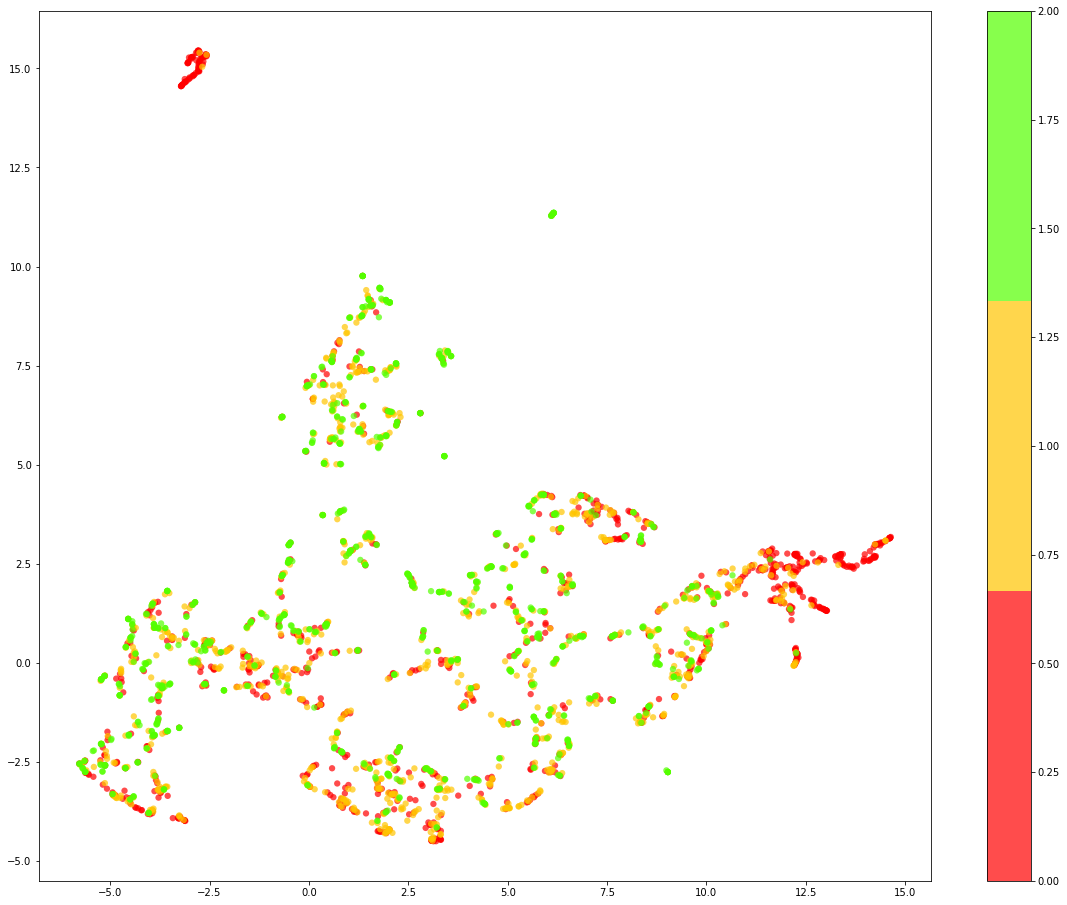

In [9]:
print('Projecting %d-dimensional data to 2D' % x.shape[1])

plt.figure(figsize=(20, 16))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('prism', 3))
plt.colorbar()
plt.show()

## Обучение без учителя

In [10]:
y_predicted = DBSCAN(min_samples=3, eps=0.3, n_jobs=16).fit_predict(x_reduced)
y_predicted

array([ 0,  1,  2, ..., 18,  0,  0], dtype=int64)

Text(0.5, 1.0, 'Кластеризация')

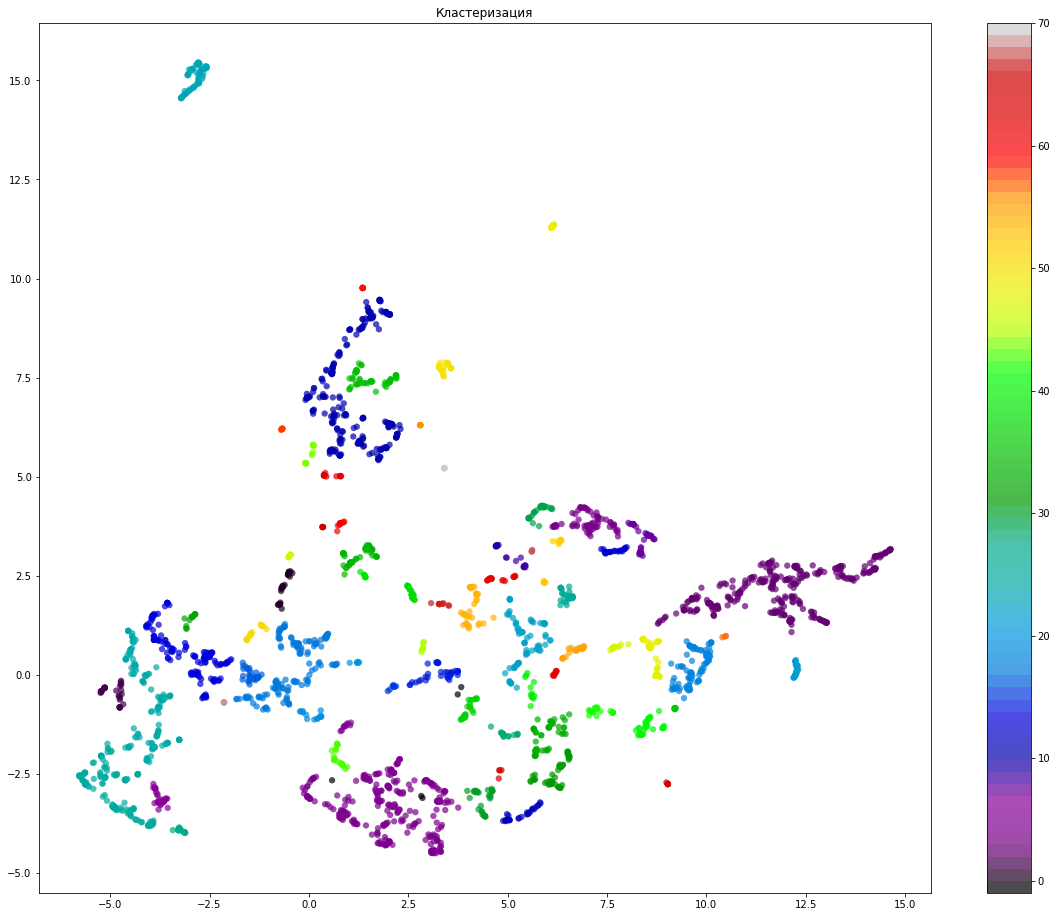

In [11]:
plt.figure(figsize=(20, 16))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_predicted,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', len(np.unique(y_predicted))))
plt.colorbar()
plt.title("Кластеризация")

## Оценка кластеризации

In [1]:
def calculate_distance(x1, x2):
    return math.sqrt((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2)

In [13]:
def calculate_on_predicted(t, f):
    return sum([sum([t(i, j) if y_predicted[i] == y_predicted[j] else f(i, j) for j in range(i + 1, n)]) for i in range(0, n)])

n = len(y_predicted)
matched_cluster_count = calculate_on_predicted(lambda i, j: 1, lambda i, j: 0)
not_matched_cluster_count = calculate_on_predicted(lambda i, j: 0, lambda i, j: 1)
print(str(matched_cluster_count) + " | " + str(not_matched_cluster_count))

193996 | 4206065


### Среднее внутрикластерное расстояние

In [14]:
f0 = calculate_on_predicted(lambda i, j: calculate_distance(x_reduced[i], x_reduced[j]), lambda i, j: 0) / matched_cluster_count
f0

1.3857363985230724

### Среднее межкластерное расстояние

In [15]:
f1 = calculate_on_predicted(lambda i, j: 0, lambda i, j: calculate_distance(x_reduced[i], x_reduced[j])) / not_matched_cluster_count
f1

8.584872950942069